# import previous models

In [1]:
import pandas as pd
import ast,json
import numpy as np
from pymatgen.core import Composition
import CompositionDeformer as compd
from tensorflow.keras.utils import to_categorical
print("hello new materials")
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import clone_model
from IPython.display import Image
import tqdm
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model

hello new materials


In [2]:
def reset_weights(model,weights=None):
    for layer in model.layers:
        print("---------------")
        print(layer)
        if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
            reset_weights(layer) #apply function recursively
            continue
        if hasattr(layer, 'cell'):
            init_container = layer.cell
        else:
            init_container = layer

        for key, initializer in init_container.__dict__.items():
            if ("kernel_initializer" or "recurrent_initializer") not in key: #is this item an initializer?
                  continue #if no, skip it
            else:
                print("key:")
                print(key)
                print("initializer:")
                print(initializer)
                weights = layer.get_weights()
                weights = [initializer(w.shape, w.dtype) for w in weights] 
                layer.set_weights(weights)

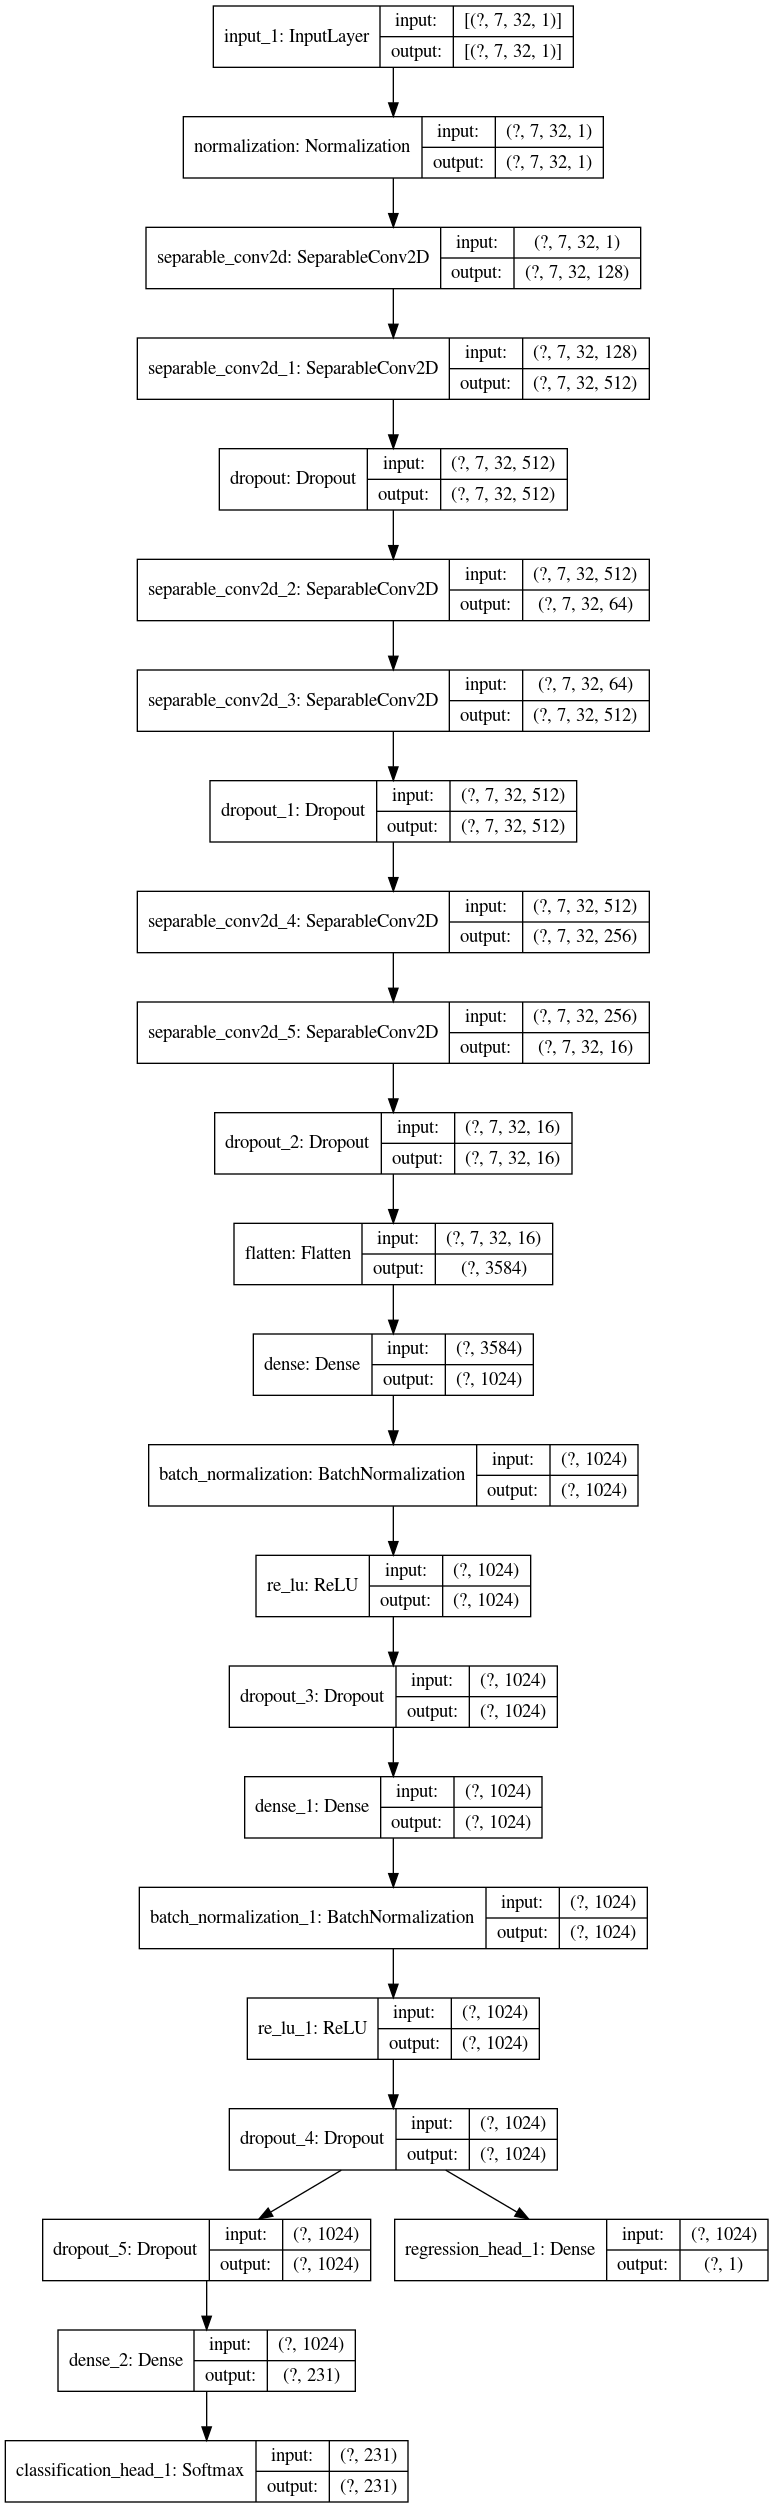

In [4]:
#load models and visualize model layers
# loaded_model= load_model("./models/release/200827_ES_custom_50ep.h5")
loaded_model= load_model("./models/201231_ES_custom_50ep_50try.h5")
plot_model(loaded_model, to_file='./loaded_model.png', show_layer_names=True, show_shapes=True)
display(Image('loaded_model.png'))

# import source data

In [5]:
# import materials project database
seeddata = pd.read_csv("./melting_points.csv")
# add 1d periodic table array and normalized magnifications
normalized_composition = []
melting_points = []

In [6]:
print(seeddata.columns)

Index(['composition', 'melting point(K)'], dtype='object')


In [7]:
normalized_compositions = []
for unit in tqdm.tqdm(seeddata["composition"]):
    composition_name = unit
    comp = Composition(composition_name)
    normalized_compositions.append(comp.fractional_composition.reduced_formula)

100%|██████████| 680/680 [00:00<00:00, 22487.44it/s]


In [8]:
#拡張周期表表記の入力配列を作成
periodic_1d_arrays = []
for i,composition_name in enumerate(normalized_compositions):
    try:
        compd.generate_extended_PT_from_composition(composition_name).get_1d_array()
    except:
        del normalized_compositions[i]
        del seeddata['melting point(K)'][i]
#入力データを2次元マップに変換
print(len(seeddata['melting point(K)']))
for comp in normalized_compositions:
    periodic_1d_arrays.append(compd.generate_extended_PT_from_composition(comp).get_1d_array())
X = np.array(periodic_1d_arrays, dtype = np.float32)
X = X.reshape((len(X),7,32))
print(X.shape)

##融点をnumpy配列化
melting_point_array = np.array(seeddata['melting point(K)'],dtype=np.float32)

678
(678, 7, 32)


In [36]:
print(len(melting_point_array))

678


In [9]:
#訓練用データセットに分ける
from sklearn.model_selection import train_test_split
#新規データとしてband gapを取得し訓練用とテスト用に分ける
X_train,X_test,meltingpoint_train,meltingpoint_test = train_test_split(X,melting_point_array,test_size=0.2)
# X_train,X_test,energy_train,energy_test,symmetry_train,symmetry_test = train_test_split(X,dropped_seeddata["normalized_energy"],symmetry_category,test_size=0.1)

# transfer learning with new data

In [14]:
for i in [-1, -2, -3, -4, -5, -6, -7,-8,-9,-10,-11,-12]:    
    layer = loaded_model.layers[i].output
    print(layer.name)

regression_head_1/BiasAdd_1:0
classification_head_1/Softmax_1:0
dense_2/BiasAdd:0
dropout_5/cond/Identity:0
dropout_4/cond/Identity:0
re_lu_1/Relu:0
batch_normalization_1/batchnorm/add_1:0
dense_1/BiasAdd_1:0
dropout_3/cond/Identity:0
re_lu/Relu_1:0
batch_normalization/batchnorm/add_1:0
dense/BiasAdd_1:0


In [30]:
#model reconstruction
# すでにあるモデルの途中から新しいモデルを作る。

##レイヤー名の取得と切断レイヤーの選別
for i in [-1, -2, -3, -4, -5, -6, -7]:    
    layer = loaded_model.layers[i].output
    print(layer.name)
##残すベース部分のアウトプット層を取得
cut_output = loaded_model.layers[-6].output
##層を追加
fc1 = Dense(256, activation="relu")(cut_output)
fc2 = Dropout(rate=0.5)(fc1)
fc2._name = "dddd"
fc3 = Dense(100, activation="relu")(fc2)
fc4 = Dense(1, activation="linear")(fc3)
##転移モデルを作成
transfered_model = Model(inputs=loaded_model.inputs, outputs=fc4)
##ベースの層の訓練を禁止
for i in range(7):
    transfered_model.layers[i].trainable = False
transfered_model.summary()

##訓練用モデルを構築
transfered_model.compile(loss="mse", optimizer="adam", metrics=["mae"])

regression_head_1/BiasAdd_1:0
classification_head_1/Softmax_1:0
dense_2/BiasAdd:0
dropout_5/cond/Identity:0
dropout_4/cond/Identity:0
re_lu_1/Relu:0
batch_normalization_1/batchnorm/add_1:0
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 32, 1)]        0         
_________________________________________________________________
normalization (Normalization (None, 7, 32, 1)          3         
_________________________________________________________________
separable_conv2d (SeparableC (None, 7, 32, 128)        281       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 7, 32, 512)        69248     
_________________________________________________________________
dropout (Dropout)            (None, 7, 32, 512)        0         
_______________________________________________________________

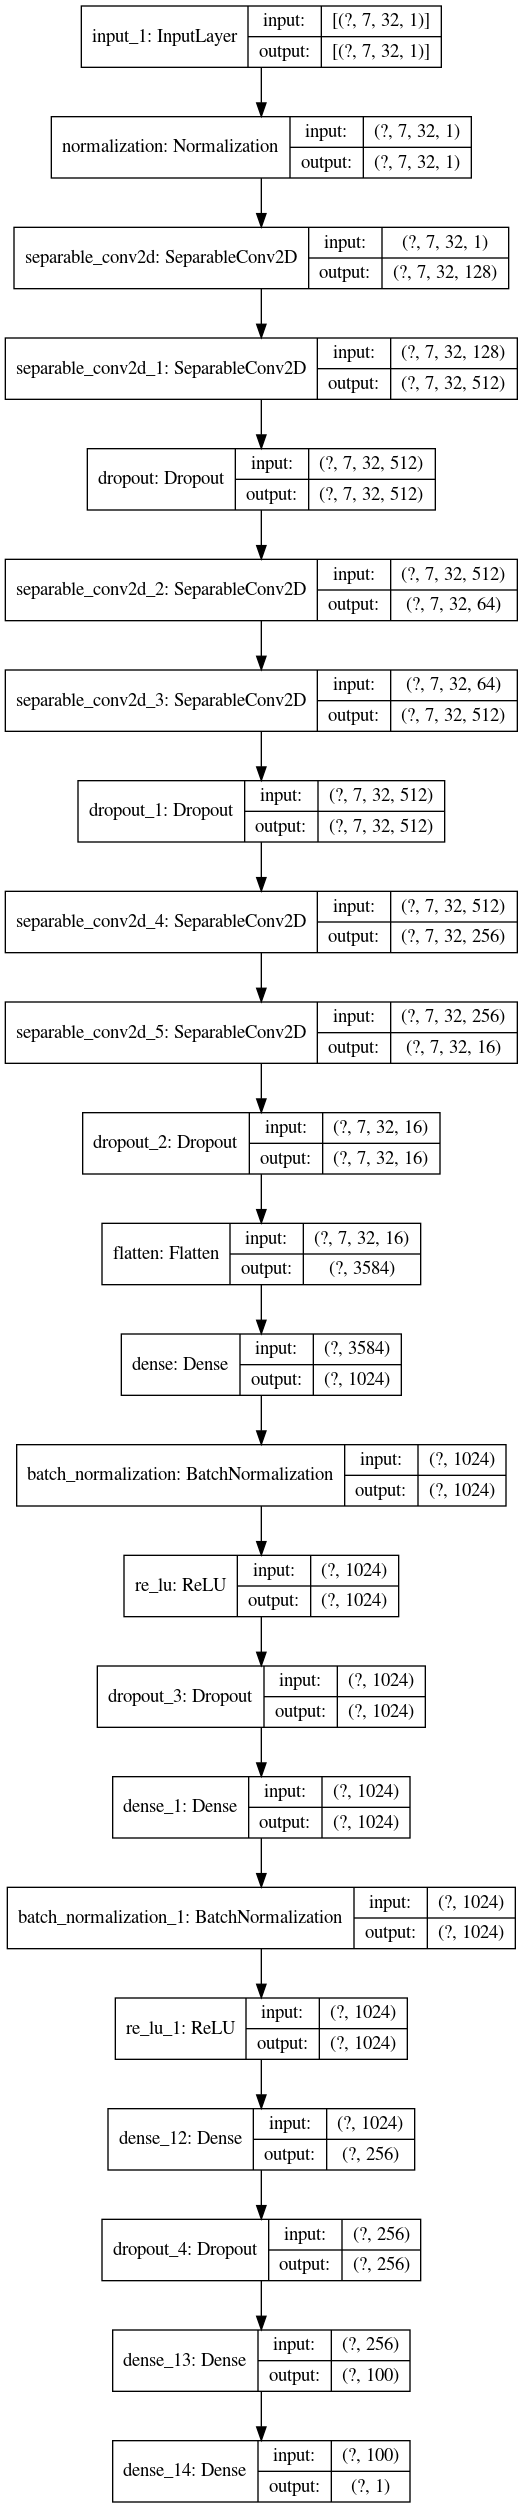

In [17]:
#visualization of transfer learning model
plot_model(transfered_model, to_file='./transfered_melting_model_210114.png', show_layer_names=True, show_shapes=True)
display(Image('transfered_melting_model_210114.png'))

In [31]:
#limit inputs
data_limit = 400
limited_X = X_train[:data_limit]
validation_X = X_train[data_limit:]

limited_meltingpoint = meltingpoint_train[:data_limit]
validation_meltingpoint = meltingpoint_train[data_limit:]

transfered_history = transfered_model.fit(limited_X, limited_meltingpoint, epochs=25, validation_split=0.1,batch_size=64)

Epoch 1/25
6/6 [==============================] - 0s 32ms/step - loss: 3246371.5000 - mae: 1635.7700 - val_loss: 3079855.5000 - val_mae: 1536.7013
Epoch 2/25
6/6 [==============================] - 0s 11ms/step - loss: 3217907.2500 - mae: 1628.6251 - val_loss: 3037940.2500 - val_mae: 1526.6127
Epoch 3/25
6/6 [==============================] - 0s 11ms/step - loss: 3156671.0000 - mae: 1613.6755 - val_loss: 2955830.5000 - val_mae: 1507.1881
Epoch 4/25
6/6 [==============================] - 0s 13ms/step - loss: 3042187.7500 - mae: 1586.1805 - val_loss: 2808957.5000 - val_mae: 1472.9576
Epoch 5/25
6/6 [==============================] - 0s 14ms/step - loss: 2858265.2500 - mae: 1540.2991 - val_loss: 2563226.2500 - val_mae: 1414.9944
Epoch 6/25
6/6 [==============================] - 0s 16ms/step - loss: 2568575.7500 - mae: 1467.4863 - val_loss: 2184532.5000 - val_mae: 1320.4106
Epoch 7/25
6/6 [==============================] - 0s 14ms/step - loss: 2143260.5000 - mae: 1353.5359 - val_loss: 16763

In [19]:
transfered_model.evaluate(validation_X, validation_meltingpoint)

5/5 [==============================] - 0s 8ms/step - loss: 71648.0312 - mae: 184.5043


[71648.03125, 184.50425720214844]

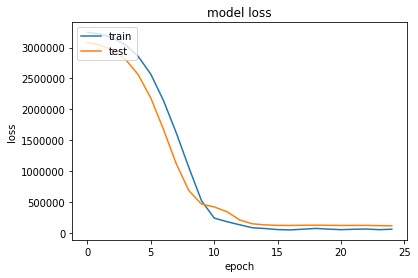

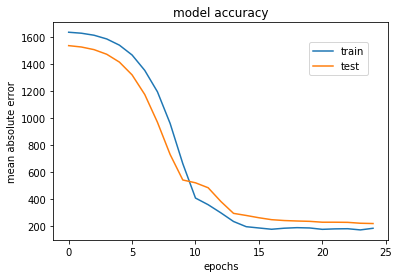

In [32]:
import matplotlib.pyplot as plt
# 損失値をグラフ表示
history = transfered_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 正解率をグラフ表示
plt.plot(history.history['mae'],label="train")
plt.plot(history.history['val_mae'],label="test")
plt.title('model accuracy')
plt.ylabel('mean absolute error')
plt.xlabel('epochs')
# plt.legend(['train', 'test'], loc='upper right')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=2, fontsize=10)
plt.savefig("./transfer_evaluation.png",dpi=200)
plt.show()

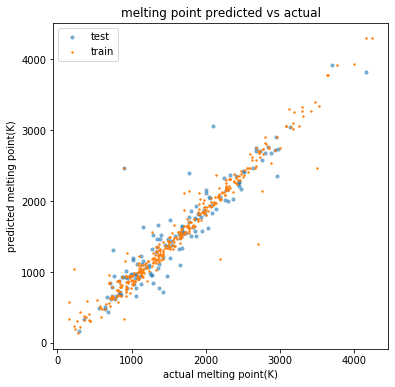

R2 test: 0.8518547817712484
R2 train: 0.9369870167272957


In [33]:
#予測値と実測値の描画
import matplotlib.pyplot as plt
#visualization of train and test prediction
## energy
predicted_bandgap_train = transfered_model.predict(limited_X)
predicted_bandgap_test = transfered_model.predict(validation_X)
plt.figure(figsize=(6,6))
plt.scatter(validation_meltingpoint,predicted_bandgap_test,alpha =0.5,s=10,label="test")
plt.scatter(limited_meltingpoint,predicted_bandgap_train,s=2,label="train")
plt.title('melting point predicted vs actual')
# plt.xlim(-12.5,0)
# plt.ylim(-12.5,0)
plt.ylabel('predicted melting point(K)')
plt.xlabel('actual melting point(K)')
plt.legend(loc='upper left')
plt.savefig("./mpoint_test_train.png",dpi=200)
plt.show()
#R^2値
from sklearn.metrics import r2_score
print("R2 test: {}".format(r2_score(validation_meltingpoint,predicted_bandgap_test)))
print("R2 train: {}".format(r2_score(limited_meltingpoint,predicted_bandgap_train)))

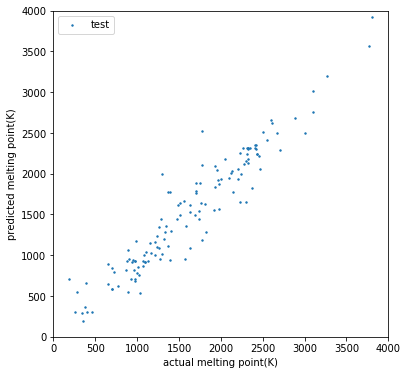

R2: 0.889131867728653


In [34]:
#test値の評価
import matplotlib.pyplot as plt
#visualization of train and test prediction
## energy
predicted_bandgap_test = transfered_model.predict(X_test)
plt.figure(figsize=(6,6))
plt.scatter(meltingpoint_test,predicted_bandgap_test,alpha =1,s=2)
plt.title('')
plt.xlim(0,4000)
plt.ylim(0,4000)
plt.ylabel('predicted melting point(K)')
plt.xlabel('actual melting point(K)')
plt.legend(['test'], loc='upper left')
plt.savefig("./mpoint_unknownsamples.png",dpi=200)
plt.show()

#R^2値
from sklearn.metrics import r2_score
print("R2: {}".format(r2_score(meltingpoint_test, predicted_bandgap_test)))

In [42]:
demo_1d_arrays = []
for i,composition_name in enumerate(["TiO2"]):
    demo_1d_arrays.append(compd.generate_extended_PT_from_composition(composition_name).get_1d_array())
#入力データを2次元マップに変換
demo_data = np.array(demo_1d_arrays, dtype = np.float32)
demo_data = demo_data.reshape((len(demo_data),7,32))
print(demo_data.shape)

result = transfered_model.predict(demo_data)
print(result)

(1, 7, 32)
[[1937.0082]]
